In [1]:
# standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# some helpful imports from sklearn
from sklearn.model_selection import RepeatedKFold

# some helpful imports from sklearndf
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF


# relevant FACET imports
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid
from facet.inspection import LearnerInspector


# FACET imports
from facet.validation import BootstrapCV
from facet.crossfit import LearnerCrossfit
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer
from facet.simulation import UnivariateProbabilitySimulator


#shap import
import shap

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 500)

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_train['Sex']=df_train['Sex'].astype("category").cat.codes
df_train['Cabin']=df_train['Cabin'].astype("category").cat.codes
df_train['Embarked']=df_train['Embarked'].astype("category").cat.codes
df_train['Ticket']=df_train['Ticket'].astype("category").cat.codes
df_train['Name']=df_train['Name'].astype("category").cat.codes


In [5]:
df_train = df_train.dropna()
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,108,1,22.0,1,0,523,7.2500,-1,2
1,2,1,1,190,0,38.0,1,0,596,71.2833,81,0
2,3,1,3,353,0,26.0,0,0,669,7.9250,-1,2
3,4,1,1,272,0,35.0,1,0,49,53.1000,55,2
4,5,0,3,15,1,35.0,0,0,472,8.0500,-1,2
6,7,0,1,515,1,54.0,0,0,85,51.8625,129,2
7,8,0,3,624,1,2.0,3,1,395,21.0750,-1,2
8,9,1,3,412,0,27.0,0,2,344,11.1333,-1,2
9,10,1,2,576,0,14.0,1,0,132,30.0708,-1,0
10,11,1,3,727,0,4.0,1,1,616,16.7000,145,2


In [6]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  714 non-null    int64  
 1   Survived     714 non-null    int64  
 2   Pclass       714 non-null    int64  
 3   Name         714 non-null    int16  
 4   Sex          714 non-null    int8   
 5   Age          714 non-null    float64
 6   SibSp        714 non-null    int64  
 7   Parch        714 non-null    int64  
 8   Ticket       714 non-null    int16  
 9   Fare         714 non-null    float64
 10  Cabin        714 non-null    int16  
 11  Embarked     714 non-null    int8   
dtypes: float64(2), int16(3), int64(5), int8(2)
memory usage: 50.2 KB


In [7]:
df_train.describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,422.542017,0.634454,29.699118,0.512605,0.431373,335.406162,34.694514,19.112045,1.588235
std,259.119524,0.491460,0.838250,264.021184,0.481921,14.526497,0.929783,0.853289,203.457651,52.918930,40.199067,0.789963
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,222.250000,0.000000,1.000000,189.250000,0.000000,20.125000,0.000000,0.000000,152.250000,8.050000,-1.000000,2.000000
50%,445.000000,0.000000,2.000000,397.500000,1.000000,28.000000,0.000000,0.000000,331.000000,15.741700,-1.000000,2.000000
75%,677.750000,1.000000,3.000000,656.750000,1.000000,38.000000,1.000000,1.000000,530.750000,33.375000,7.750000,2.000000
max,891.000000,1.000000,3.000000,889.000000,1.000000,80.000000,5.000000,6.000000,680.000000,512.329200,146.000000,2.000000


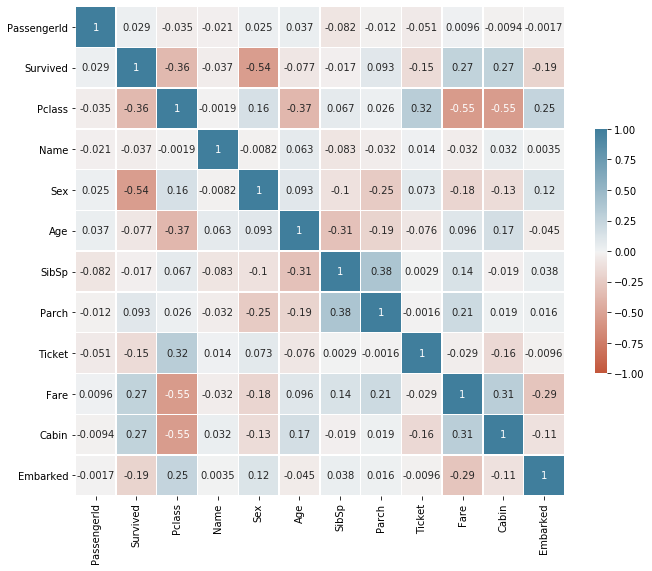

In [8]:
corr = df_train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True,cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
#survived proportion under 40
df_train[df_train['Age']<40]['Survived'].mean()

0.41560798548094374

In [20]:
#survived proportion equal to or over 40
df_train[df_train['Age']>=40]['Survived'].mean()

0.37423312883435583

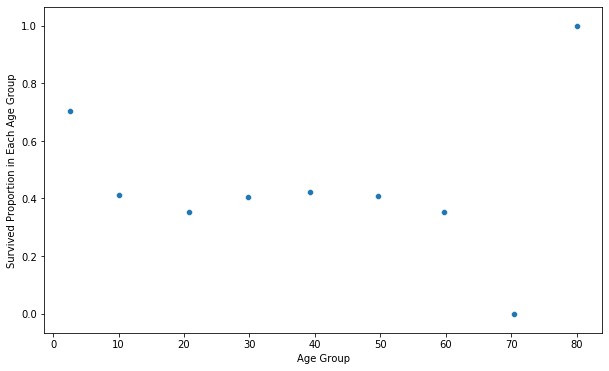

In [9]:
#survived proportion group age to nearest 10 years (e.g. proportion survived when age round to 10 years)
ax = sns.scatterplot(data=df_train.groupby(round(df_train['Age'],-1)).mean(),y='Survived',x='Age')
ax.set(xlabel='Age Group', ylabel='Survived Proportion in Each Age Group')

plt.gcf().set_size_inches(10, 6)


## bcg gamma facet below

In [10]:
# create FACET sample object
titanic_sample = Sample(observations=df_train, target_name="Survived")

# create a (trivial) pipeline for a random forest regressor
rnd_forest = ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(random_state=42)
)

# define grid of models which are "competing" against each other
rnd_forest_grid = [
    LearnerGrid(
        pipeline=rnd_forest,
        learner_parameters={
            "min_samples_leaf": [2,4,6]
        }
    ),
]

# create repeated k-fold CV iterator
rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# rank your candidate models by performance (default is mean CV score - 2*SD)
ranker = LearnerRanker(
    grids=rnd_forest_grid, cv=rkf_cv, n_jobs=-1
).fit(sample=titanic_sample)

# get summary report
ranker.summary_report()

ranking_score accuracy_score                          classifier  \
                             mean       std                      type   
rank                                                                    
0         0.766654       0.820991  0.027169  RandomForestClassifierDF   
1         0.760677       0.816229  0.027776  RandomForestClassifierDF   
2         0.757507       0.818182  0.030338  RandomForestClassifierDF   

                       
     min_samples_leaf  
rank                   
0                   2  
1                   6  
2                   4

In [11]:
# run inspector
clf_inspector = LearnerInspector(
    n_jobs=-1,
    verbose=True,
).fit(crossfit=ranker.best_model_crossfit_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished


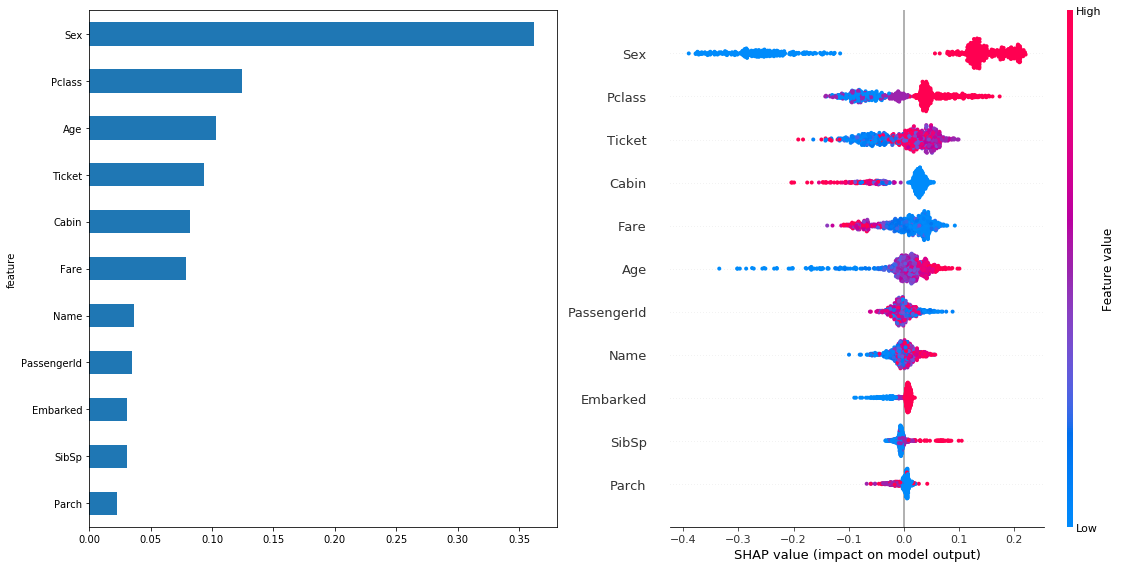

In [12]:
# FACET feature importance
f_importance = clf_inspector.feature_importance()
plt.subplot(1, 2, 1)
f_importance.sort_values().plot.barh()

# get some info for standard SHAP model inspection
shap_data = clf_inspector.shap_plot_data()

# standard SHAP summary plot using the shap package
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values=shap_data.shap_values, features=shap_data.features, show=False, plot_size=(16.0, 8.0))
plt.tight_layout()

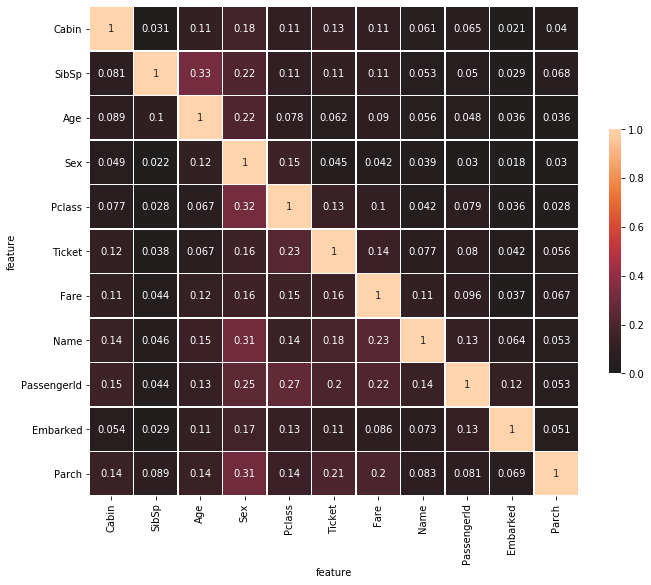

In [13]:
# synergy heatmap
# visualise synergy as a matrix

synergy_matrix = clf_inspector.feature_synergy_matrix()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(synergy_matrix, annot=True, vmin=0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

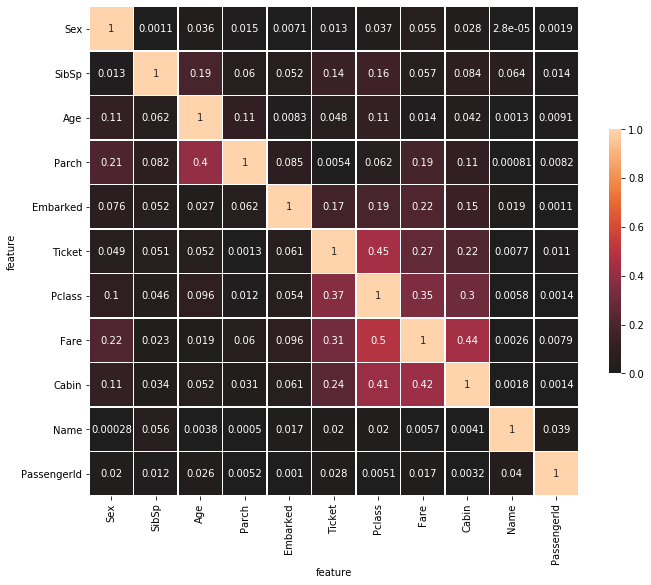

In [14]:
# redundancy heatmap
redundancy_matrix = clf_inspector.feature_redundancy_matrix()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(redundancy_matrix, annot=True, vmin=0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Redundancy Heatmap", fontsize =20)


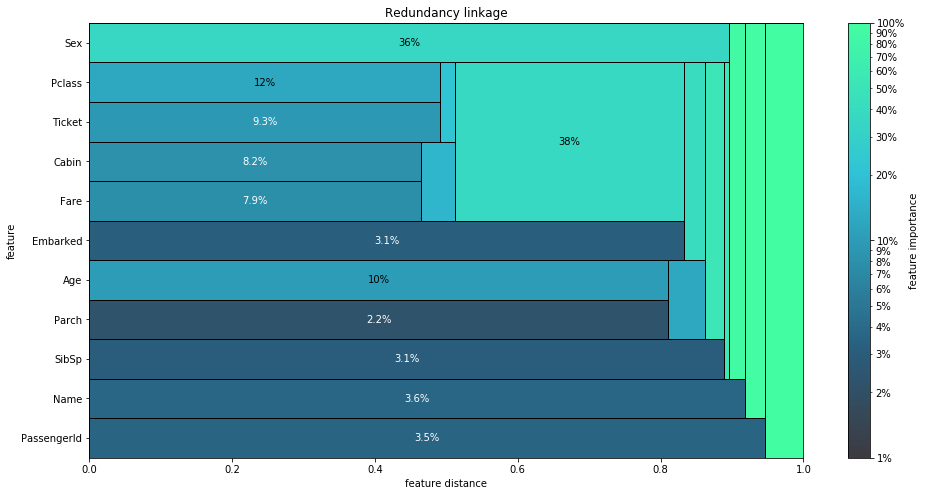

In [15]:
# redundancy dendrogram
dd_redundancy = clf_inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(title="Redundancy linkage", data=dd_redundancy)
plt.gcf().set_size_inches(16, 8)


In [16]:
# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model_,
    cv=BootstrapCV(n_splits=1000, random_state=42),
    n_jobs=-1,
    verbose=False,
).fit(sample=titanic_sample)

In [17]:
# set-up and run a simulation
sim_feature = "Age"

age_simulator = UnivariateProbabilitySimulator(
    crossfit=boot_crossfit,
    n_jobs=-1
)

age_partitions = ContinuousRangePartitioner()

age_simulation = age_simulator.simulate_feature(
    feature_name=sim_feature,
    partitioner=age_partitions
)

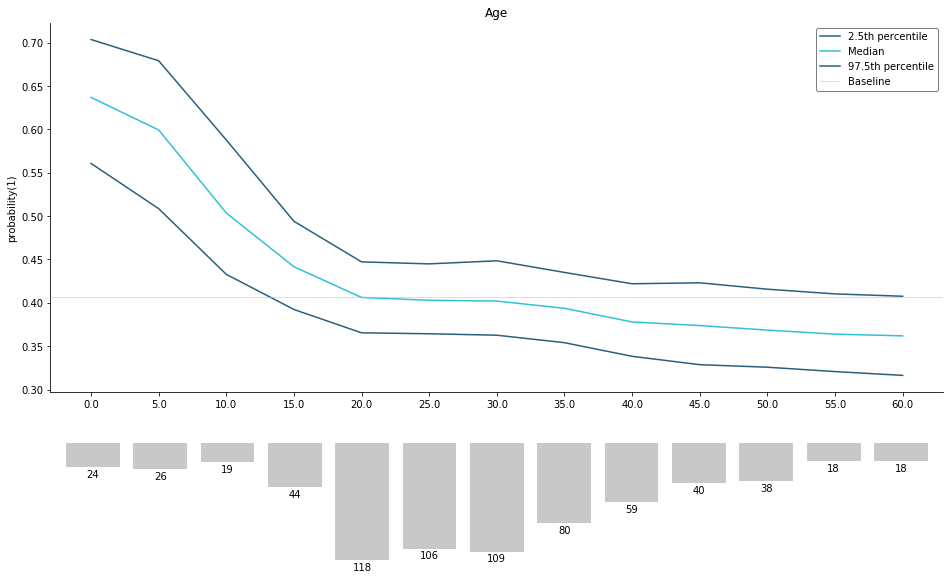

In [18]:
# visualize the results
SimulationDrawer().draw(data=age_simulation, title=sim_feature)

plt.gcf().set_size_inches(16, 10)
